In [14]:
from tensorflow import keras
import pandas as pd
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
from utils import *

In [2]:
nFeat = 6
trainsize = 499889
intermediate_dim = 128
encoder_dim = 128
batch_size = 1024
latent_dim = 6
epochs = 240
eluvar = np.sqrt(1.55/intermediate_dim)

folder = "/global/homes/a/agarabag/pscratch/GAEA/outputs/models/cVAEz6_03-27-2023"

In [3]:
decoder = keras.models.load_model(folder+'/model_cbvae_6var_m239.h5')

2023-03-27 15:57:54.701471: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 15:57:56.203922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 26017 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [4]:
list_of_decoders = [decoder]

In [5]:
encoder = keras.models.load_model(folder+'/encoder_cbvae_6var_m239.h5')

In [6]:
list_of_encoders = [encoder]

In [25]:
test_mean =  np.load("/global/homes/a/agarabag/pscratch/cbvae/model_save/best_latent_mean_6var_6var_adam_NoF.npy")
print(test_mean.shape)

(499889, 20)


## Load SR data

In [7]:
innerdata_train = np.load("./data/preprocessed_data_6var/innerdata_train_6var.npy")
innerdata_train = innerdata_train[innerdata_train[:,nFeat+1]==0]

In [8]:
# check number of total events & bkg in innerdata_train

pd_innerdata_train = pd.DataFrame(innerdata_train, columns=["mjj", "mjmin", "mjmax-mjmin", "tau21j1", "tau21j2", "tau32j1", "tau32j2", "label"])
print("number of events in innerdata_train:", len(pd_innerdata_train))
pd_innerdata_train_bkg = pd_innerdata_train[pd_innerdata_train["label"]==0]
print("number of events in innerdata with label=0 (bkg):", len(pd_innerdata_train_bkg))

number of events in innerdata_train: 59605
number of events in innerdata with label=0 (bkg): 59605


In [9]:
X_innerdata_train = innerdata_train[:,1:nFeat+1]
y_innerdata_train = innerdata_train[:,0]

print("shape of X_innerdata_train:", X_innerdata_train.shape)
print("shape of y_innerdata_train:", y_innerdata_train.shape)

shape of X_innerdata_train: (59605, 6)
shape of y_innerdata_train: (59605,)


In [10]:
train_features = ["mjmin", "mjmax_minus_mjmin", "tau21j1", "tau21j2", "tau32j1", "tau32j2"]
# train_features = ["mjmin"]
condition_features = ["mjj"]

nFeat = len(train_features)

## Load SB data

In [15]:
# create scaler

outerdata_train = np.load("./data/preprocessed_data_6var/outerdata_train_6var.npy")
outerdata_test = np.load("./data/preprocessed_data_6var/outerdata_test_6var.npy")
outerdata_train = outerdata_train[outerdata_train[:,nFeat+1]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat+1]==0]

X_data_train_unscaled = outerdata_train[:,1:nFeat+1]
y_data_train_unscaled = outerdata_train[:,0]

X_data_test_unscaled = outerdata_test[:,1:nFeat+1]
y_data_test_unscaled = outerdata_test[:,0]

X_data_unscaled = np.concatenate((X_data_train_unscaled, X_data_test_unscaled), axis=0)
X_data = np.copy(X_data_unscaled)
y_data = np.concatenate((y_data_train_unscaled, y_data_test_unscaled), axis=0)

# scaler = MinMaxScaler((0,1)).fit(X_data)
# scaler_mjj = MinMaxScaler((0,1)).fit(y_data.reshape(-1,1))

# x_max = np.empty(nFeat)
# for i in range(0,X_data.shape[1]):
#     x_max[i] = np.max(np.abs(X_data[:,i]))
#     if np.abs(x_max[i]) > 0: 
#         X_data[:,i] = X_data[:,i]/x_max[i]
#     else:
#         pass

# cond_max = np.max(np.abs(y_data))
# if np.abs(cond_max) > 0:
#     y_data = y_data/cond_max
# else:
#     pass

X_data, data_max, data_min = minmax_norm_data(X_data)
y_data, cond_data_max, cond_data_min  = minmax_norm_cond_data(y_data)


In [16]:
y_data.shape

(878648,)

In [17]:
def generate_cond_data(n_model,stats,y_samples):
    z_samples = np.empty([stats,latent_dim])

    mean = list_of_encoders[n_model].predict([X_data[:trainsize], y_data[:trainsize]])[0]
    logvar = list_of_encoders[n_model].predict([X_data[:trainsize], y_data[:trainsize]])[1]
    var = np.exp(logvar)
    std = np.sqrt(var)

    l=0
    for i in range(0,stats):
        for j in range(0,latent_dim):
            z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
        l=l+1
    new_events = list_of_decoders[n_model].predict([z_samples, y_samples])
    
    return new_events

In [18]:
nEvent_per_model = trainsize
fake_SRs = []
for i in range(len(list_of_decoders)):

    fake_SR = generate_cond_data(i,nEvent_per_model,y_data[:trainsize])
    print(fake_SR.shape[0])

    for i in range(0,fake_SR.shape[1]):
    	fake_SR[:,i]=fake_SR[:,i]*x_max[i]

    fake_SRs.append(fake_SR)

2023-03-27 15:59:46.173581: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-27 15:59:48.666010: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


499889


In [19]:

plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]
variables_names =  train_features
vnames = train_features

def fake_vs_real(gen_data,real_data,doLog,names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in real_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="SR Bkg", density=True)        
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Generated Bkg %s"%names[i], density=True)
        plt.hist(X_data_unscaled[:,p], R, color="red", histtype='step', linewidth=2, label="SB Bkg", density=True)
        # s_hist_y, s_hist_x, _ = plt.hist(sig_data[:,p], R, color="r", histtype='step', linewidth=3, label="Signal", density=True)
        plt.xlabel("%s"%variables_names[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")
        ymax_b = np.max(b_hist_y)
        # ymax_s = np.max(s_hist_y)
        plt.ylim(0,ymax_b*1.5)
#     plt.savefig("fake_gen_compare_cbvae_6var_dynamicbeta.png")

/tmp/ipykernel_216460/3004731836.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,ymax_b*1.5)


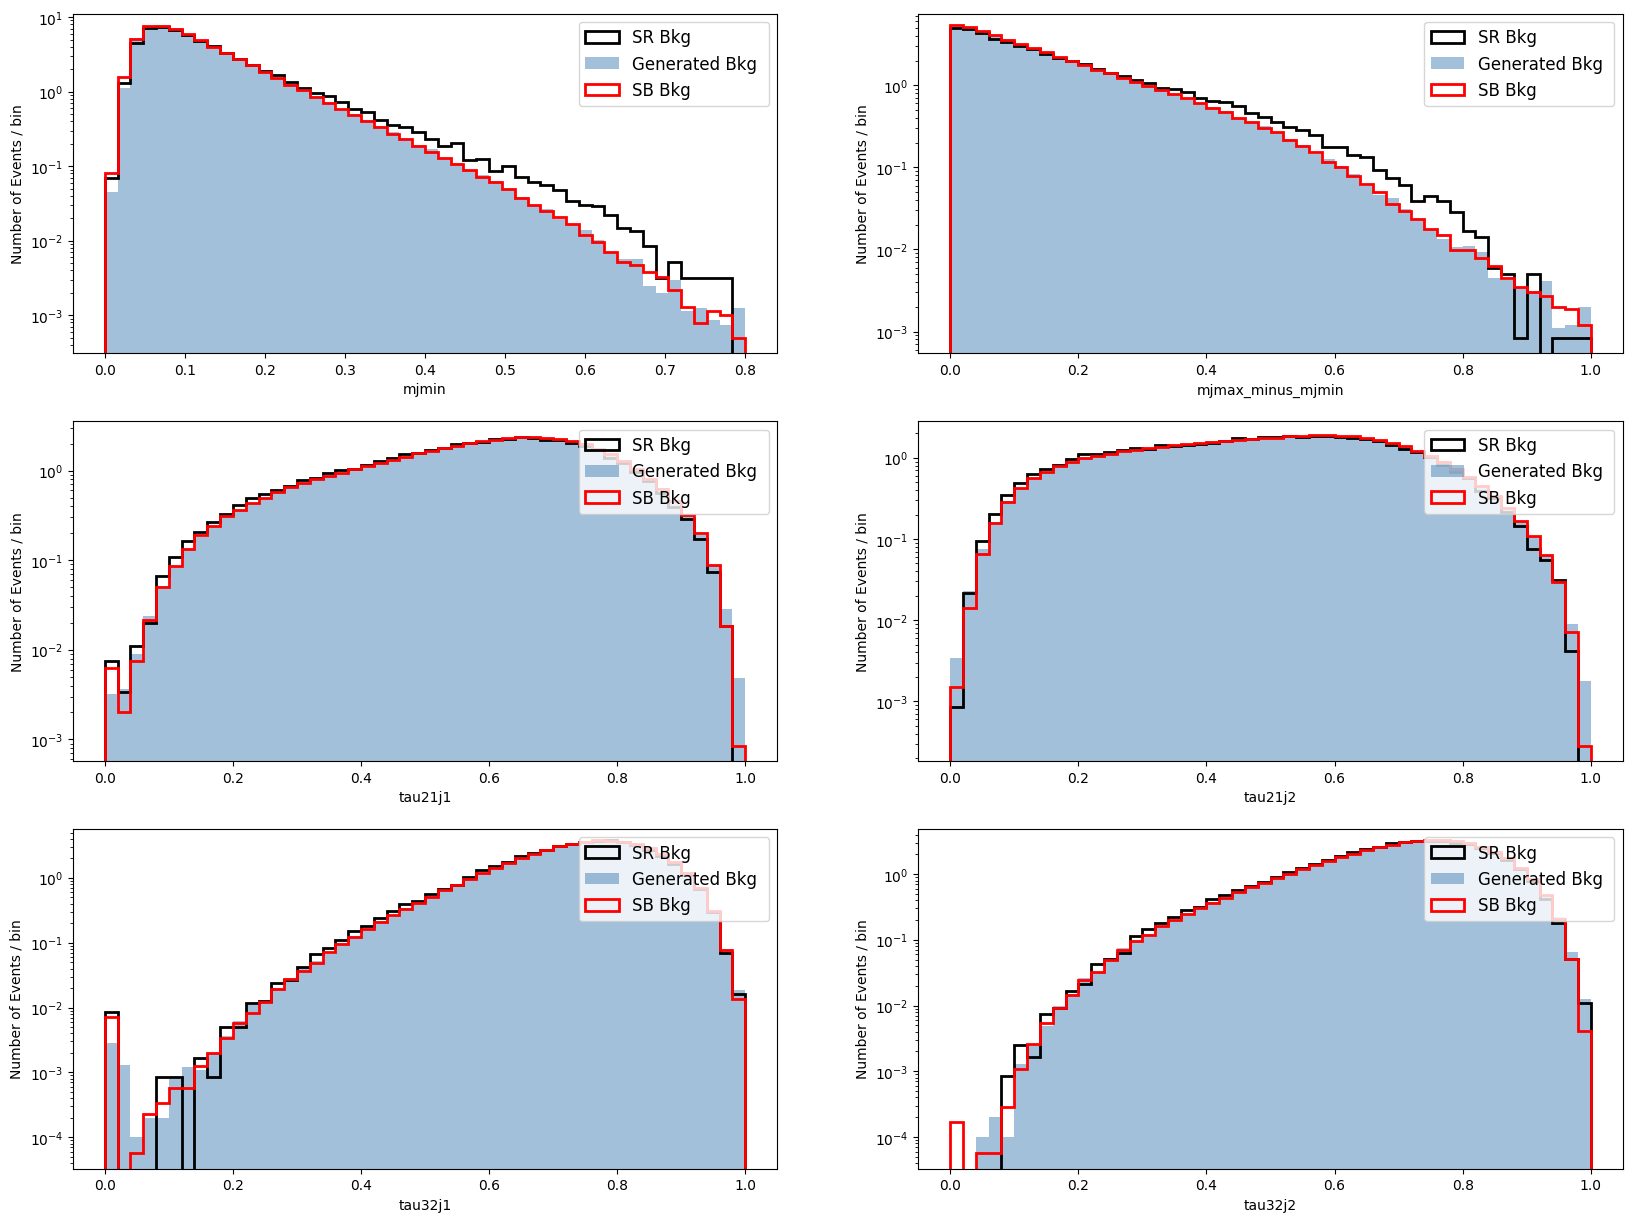

In [20]:
fake_vs_real([np.reshape(fake_SRs, (trainsize,nFeat))],[X_innerdata_train],1,[""])